In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


import os
import json
import pickle
import torch
from datetime import datetime

# load data
---

In [6]:
df_or = pd.read_csv('Mental_Health/mental_heath_all.csv')

In [7]:
# 初始處理
df = df_or.copy()
df = df.drop(columns = ['author','date'])

# 將資料分成兩個部份，分別文純語句，和純features
df_post = df.loc[:,:'post']
df_features = df.drop(columns = 'post')

In [24]:
# 創建目錄
os.makedirs('data/processed', exist_ok=True)

# 保存基礎數據
df_post.to_csv('data/processed/post_data.csv', index=False)
df_features.to_csv('data/processed/features_data.csv', index=False)

# 保存索引
torch.save({
    'train_indices': train_indices,
    'test_indices': test_indices
}, 'data/processed/split_indices.pt')

print("數據保存完成：")
print("- Post data saved to: data/processed/post_data.csv")
print("- Features data saved to: data/processed/features_data.csv")
print("- Split indices saved to: data/processed/split_indices.pt")

數據保存完成：
- Post data saved to: data/processed/post_data.csv
- Features data saved to: data/processed/features_data.csv
- Split indices saved to: data/processed/split_indices.pt


# xgboost
---

In [26]:
# 1. 初始化 LabelEncoder
label_encoder = LabelEncoder()

# 2. 對 df_features 中的 'subreddit' 列進行轉換
y_encoded = label_encoder.fit_transform(df_features['subreddit'])

# 3. 查看轉換結果和對應關係
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("標籤對應關係：")
for original, encoded in label_mapping.items():
    print(f"{original}: {encoded}")

# 特徵 X
X = df_features.drop('subreddit', axis=1)  # 移除原始標籤列
# 標籤 y
y = y_encoded  # 使用剛才編碼的結果


標籤對應關係：
COVID19_support: 0
EDAnonymous: 1
addiction: 2
adhd: 3
alcoholism: 4
anxiety: 5
autism: 6
bipolarreddit: 7
bpd: 8
conspiracy: 9
depression: 10
divorce: 11
fitness: 12
guns: 13
healthanxiety: 14
jokes: 15
legaladvice: 16
lonely: 17
meditation: 18
mentalhealth: 19
parenting: 20
personalfinance: 21
ptsd: 22
relationships: 23
schizophrenia: 24
socialanxiety: 25


In [30]:
# 切割資料
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # 確保各類別比例一致
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (819260, 346)
Testing set shape: (204815, 346)


In [34]:
# 建立支援 GPU 的 XGBoost 模型
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # 多分類任務
    num_class=26,              # 類別數量
    random_state=42,
    tree_method='gpu_hist',    # 使用 GPU 加速
    gpu_id=0                   # 指定 GPU ID，如果有多個 GPU 可以改變這個值
)

# 進行 5-fold 交叉驗證
cv_scores = cross_val_score(
    xgb_model, 
    X_train, 
    y_train, 
    cv=5,
    scoring='accuracy',  
    n_jobs=-1           
)

# 輸出交叉驗證結果
print("Cross-validation scores:", cv_scores)
print("Average CV score: {:.4f} (+/- {:.4f})".format(cv_scores.mean(), cv_scores.std() * 2))

/home/harry/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:20:58] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/home/harry/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:20:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/harry/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:20:58] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/home/harry/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:20:58] WARNING: /workspace/src/c

Cross-validation scores: [0.70673535 0.7068452  0.70885311 0.70668652 0.70821229]
Average CV score: 0.7075 (+/- 0.0018)


In [36]:
# 使用全部訓練資料訓練模型
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=26,
    random_state=42,
    tree_method='hist',
    device='cuda'
)

# 訓練模型
xgb_model.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = xgb_model.predict(X_test)

# 輸出詳細的評估報告
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 計算整體準確率
accuracy = (y_test == y_pred).mean()
print(f"\nOverall Accuracy: {accuracy:.4f}")

/home/harry/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:31:22] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Classification Report:
                 precision    recall  f1-score   support

COVID19_support       0.39      0.04      0.07       196
    EDAnonymous       0.64      0.55      0.59      2915
      addiction       0.67      0.58      0.62      1528
           adhd       0.75      0.69      0.72      9126
     alcoholism       0.62      0.63      0.63      1182
        anxiety       0.63      0.66      0.64     11534
         autism       0.52      0.18      0.27      1774
  bipolarreddit       0.42      0.07      0.11      1156
            bpd       0.75      0.49      0.59      4859
     conspiracy       0.63      0.64      0.64      5969
     depression       0.61      0.75      0.67     23466
        divorce       0.63      0.46      0.53      2519
        fitness       0.78      0.83      0.80      9969
           guns       0.84      0.79      0.81      4595
  healthanxiety       0.63      0.45      0.52      1730
          jokes       0.82      0.93      0.87     18901
    leg

In [89]:
def save_xgboost_model(model, metrics, save_dir='base_models/xgboost'):
    """保存XGBoost模型和相關信息"""
    # 確保目錄存在
    os.makedirs(save_dir, exist_ok=True)
    
    # 保存模型
    model.save_model(os.path.join(save_dir, 'xgboost_model.json'))
    
    # 保存配置信息
    config = {
        'metrics': metrics,
        'saved_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_version': '1.0'
    }
    
    with open(os.path.join(save_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=4)
    
    print(f"XGBoost model saved to {save_dir}")

def save_label_encoder(label_encoder, save_dir='base_models/encoder'):
    """保存標籤編碼器"""
    # 確保目錄存在
    os.makedirs(save_dir, exist_ok=True)
    
    # 保存label encoder
    with open(os.path.join(save_dir, 'label_encoder.pkl'), 'wb') as f:
        pickle.dump(label_encoder, f)
    
    print(f"Label encoder saved to {save_dir}")

In [90]:
# XGBoost模型
xgb_metrics = {
    'accuracy': 0.7095,
    'weighted_f1': 0.70
}

save_xgboost_model(xgb_model, xgb_metrics)

save_label_encoder(label_encoder)

XGBoost model saved to base_models/xgboost
Label encoder saved to base_models/encoder


# PLM
---

In [18]:
import torch
from torch import nn
from transformers import AutoTokenizer
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [46]:
# 確保使用相同的label_encoder
y_text = label_encoder.transform(df_post['subreddit'])

In [42]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# 計算每段文本的token長度
lengths = [len(tokenizer.encode(text)) for text in df_post['post']]

# 看一下基本統計資訊
print("Text length statistics:")
print(f"Mean length: {np.mean(lengths):.2f}")
print(f"Median length: {np.median(lengths):.2f}")
print(f"95th percentile: {np.percentile(lengths, 95):.2f}")
print(f"Max length: {max(lengths)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (684 > 512). Running this sequence through the model will result in indexing errors


Text length statistics:
Mean length: 228.28
Median length: 163.00
95th percentile: 649.00
Max length: 11939


* 將文字做前處理
---

In [45]:
def preprocess_text(text):
    """基本的文本清理"""
    if isinstance(text, str):
        # 移除多餘的空白
        text = ' '.join(text.split())
        # 轉換為小寫
        text = text.lower()
        return text
    return ''

def tokenize_data(df_post, batch_size=32):
    """分批對文本進行tokenization"""
    
    # 初始化tokenizer
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    
    # 預處理文本
    print("正在清理文本...")
    texts = [preprocess_text(text) for text in tqdm(df_post['post'].tolist())]
    
    # 計算tokenization前的文本長度統計
    text_lengths = [len(text.split()) for text in texts]
    print(f"\n文本長度統計:")
    print(f"平均長度: {np.mean(text_lengths):.2f}")
    print(f"中位數長度: {np.median(text_lengths):.2f}")
    print(f"95百分位數: {np.percentile(text_lengths, 95):.2f}")
    print(f"最大長度: {max(text_lengths)}")
    
    # 初始化儲存列表
    all_input_ids = []
    all_attention_masks = []
    truncated_count = 0
    
    # 分批處理
    print("\n開始tokenization...")
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        
        # 執行tokenization
        encoded = tokenizer(
            batch_texts,
            add_special_tokens=True,
            return_attention_mask=True,
            padding='max_length',  # 使用動態padding
            max_length=512,
            truncation=True,
            return_tensors='pt'
        )
        
        # 檢查是否有被截斷的文本
        for j, text in enumerate(batch_texts):
            tokens = tokenizer.tokenize(text)
            if len(tokens) > 510:  # 考慮[CLS]和[SEP]
                truncated_count += 1
        
        all_input_ids.append(encoded['input_ids'])
        all_attention_masks.append(encoded['attention_mask'])
    
    # 合併所有batch
    input_ids = torch.cat(all_input_ids, dim=0)
    attention_masks = torch.cat(all_attention_masks, dim=0)
    
    # 輸出統計信息
    print(f"\n處理完成:")
    print(f"總樣本數: {len(texts)}")
    print(f"被截斷的文本數: {truncated_count}")
    print(f"截斷比例: {(truncated_count/len(texts))*100:.2f}%")
    
    return {
        'input_ids': input_ids,
        'attention_masks': attention_masks,
        'truncated_count': truncated_count,
        'total_samples': len(texts)
    }

# 使用範例
try:
    # 假設df_post是您的DataFrame
    tokenized_data = tokenize_data(df_post)
    
    # 獲取處理後的數據
    input_ids = tokenized_data['input_ids']
    attention_masks = tokenized_data['attention_masks']
    

    # 保存完整訓練數據
    torch.save({
        'input_ids': input_ids,
        'attention_masks': attention_masks,
        'labels': torch.tensor(y_text),  # 將numpy array轉換為tensor
        'label_encoder': label_encoder   # 保存label_encoder以便之後使用
    }, '/home/harry/final/Mental_Health/tokenized_data.pt')
    print("\n數據已保存到 '/home/harry/final/Mental_Health/tokenized_data.pt'")
    
except Exception as e:
    print(f"處理過程中發生錯誤: {str(e)}")

正在清理文本...


100%|██████████| 1024075/1024075 [00:21<00:00, 47018.13it/s]



文本長度統計:
平均長度: 180.41
中位數長度: 128.00
95百分位數: 520.00
最大長度: 8403

開始tokenization...


100%|██████████| 32003/32003 [25:53<00:00, 20.60it/s]



處理完成:
總樣本數: 1024075
被截斷的文本數: 90496
截斷比例: 8.84%
處理過程中發生錯誤: name 'y_text' is not defined


* 讀取數據+準備數據(重複執行直接從這裡開始)
---

In [3]:
# 讀取所有數據
training_data = torch.load('/home/harry/final/Mental_Health/tokenized_data.pt')

# 分別獲取需要的數據
input_ids = training_data['input_ids']
attention_masks = training_data['attention_masks']
labels = training_data['labels']
label_encoder = training_data['label_encoder']  # 用於之後轉換預測結果

/tmp/ipykernel_424563/2167396230.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_data = torch.load('/home/harry/final/Mental_Health/tokenized_data.pt')


In [9]:
# 獲取訓練集和測試集的索引
indices = np.arange(len(labels))
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels  # 使用相同的stratify策略
)

# 使用這些索引切割BERT的輸入數據
train_inputs = input_ids[train_indices]
train_masks = attention_masks[train_indices]
train_labels = labels[train_indices]

val_inputs = input_ids[test_indices]
val_masks = attention_masks[test_indices]
val_labels = labels[test_indices]

# 3. 創建DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

val_dataloader = DataLoader(
    val_data,
    sampler=SequentialSampler(val_data),
    batch_size=32
)

* 載入pretrained model, 設定參數
---

In [13]:
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
# 設置GPU如果可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} for training')

# 初始化模型
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_),  # 設置輸出類別數
    output_attentions=False,
    output_hidden_states=False,
)

# 將模型移到GPU
model = model.to(device)

Using cuda for training


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# 優化器參數
optimizer = AdamW(model.parameters(),
                 lr=2e-5,  # 學習率
                 eps=1e-8  # 小數值，防止除零
                 )

# 總訓練步數
epochs = 4
total_steps = len(train_dataloader) * epochs

# 創建學習率調度器
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

/home/harry/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


* fine tuning
---

In [16]:
import time
import datetime  # 需要添加這個導入

def format_time(elapsed):
    """把秒數轉換為 hh:mm:ss 格式"""
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [76]:
def train(model, train_dataloader, val_dataloader, epochs):
    # 記錄訓練過程
    training_stats = []
    
    # 每個epoch的訓練
    for epoch_i in range(epochs):
        print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
        
        # 紀錄每個epoch的開始時間
        t0 = time.time()
        
        # 訓練
        model.train()
        total_train_loss = 0
        
        for step, batch in enumerate(train_dataloader):
            # 將數據移到GPU
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # 清除之前的梯度
            model.zero_grad()
            
            # 前向傳播
            outputs = model(b_input_ids,
                          attention_mask=b_input_mask,
                          labels=b_labels)
            
            loss = outputs.loss
            total_train_loss += loss.item()
            
            # 反向傳播
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # 更新參數
            optimizer.step()
            scheduler.step()
            
            # 每100步輸出進度
            if step % 100 == 0 and not step == 0:
                print(f'Batch {step} of {len(train_dataloader)}')
        
        # 計算平均訓練loss
        avg_train_loss = total_train_loss / len(train_dataloader)
        
        # 計算訓練時間
        training_time = format_time(time.time() - t0)
        
        print(f"Average training loss: {avg_train_loss}")
        
        # 驗證
        t0 = time.time()
        model.eval()
        total_val_loss = 0
        
        for batch in val_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with torch.no_grad():
                outputs = model(b_input_ids,
                              attention_mask=b_input_mask,
                              labels=b_labels)
            
            total_val_loss += outputs.loss.item()
            
        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_time = format_time(time.time() - t0)
        
        print(f"Validation loss: {avg_val_loss}")
        
        # 記錄每個epoch的統計數據
        training_stats.append({
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        })
    
    return training_stats  # 返回訓練統計數據

In [77]:
# 訓練模型
stats = train(model, train_dataloader, val_dataloader, epochs=4)

======== Epoch 1 / 4 ========
Batch 100 of 25602
Batch 200 of 25602
Batch 300 of 25602
Batch 400 of 25602
Batch 500 of 25602
Batch 600 of 25602
Batch 700 of 25602
Batch 800 of 25602
Batch 900 of 25602
Batch 1000 of 25602
Batch 1100 of 25602
Batch 1200 of 25602
Batch 1300 of 25602
Batch 1400 of 25602
Batch 1500 of 25602
Batch 1600 of 25602
Batch 1700 of 25602
Batch 1800 of 25602
Batch 1900 of 25602
Batch 2000 of 25602
Batch 2100 of 25602
Batch 2200 of 25602
Batch 2300 of 25602
Batch 2400 of 25602
Batch 2500 of 25602
Batch 2600 of 25602
Batch 2700 of 25602
Batch 2800 of 25602
Batch 2900 of 25602
Batch 3000 of 25602
Batch 3100 of 25602
Batch 3200 of 25602
Batch 3300 of 25602
Batch 3400 of 25602
Batch 3500 of 25602
Batch 3600 of 25602
Batch 3700 of 25602
Batch 3800 of 25602
Batch 3900 of 25602
Batch 4000 of 25602
Batch 4100 of 25602
Batch 4200 of 25602
Batch 4300 of 25602
Batch 4400 of 25602
Batch 4500 of 25602
Batch 4600 of 25602
Batch 4700 of 25602
Batch 4800 of 25602
Batch 4900 of 25602

* 驗證performence
---

In [78]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, val_dataloader, device):
    # 設置模型為評估模式
    model.eval()
    
    # 儲存預測和真實標籤
    predictions = []
    true_labels = []
    
    # 不計算梯度
    with torch.no_grad():
        for batch in val_dataloader:
            # 將數據移到GPU
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # 模型預測
            outputs = model(b_input_ids, 
                          attention_mask=b_input_mask)
            
            # 獲取預測結果
            logits = outputs.logits
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            labels = b_labels.cpu().numpy()
            
            # 儲存預測和真實標籤
            predictions.extend(pred)
            true_labels.extend(labels)
    
    # 計算準確率
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy:.4f}')
    
    # 顯示詳細的分類報告
    print('\nClassification Report:')
    print(classification_report(true_labels, predictions))
    
    return accuracy, predictions, true_labels

# 調用評估函數
accuracy, predictions, true_labels = evaluate_model(model, val_dataloader, device)

Accuracy: 0.8775

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       196
           1       0.91      0.90      0.90      2915
           2       0.85      0.83      0.84      1528
           3       0.91      0.90      0.91      9126
           4       0.85      0.89      0.87      1182
           5       0.74      0.77      0.75     11534
           6       0.86      0.81      0.83      1774
           7       0.70      0.64      0.67      1156
           8       0.80      0.73      0.76      4859
           9       0.94      0.93      0.94      5969
          10       0.75      0.82      0.79     23466
          11       0.87      0.85      0.86      2519
          12       0.98      0.98      0.98      9969
          13       0.98      0.98      0.98      4595
          14       0.79      0.74      0.76      1730
          15       0.97      0.98      0.98     18901
          16       0.95      0.95      0

In [ ]:
# 將數字標籤轉換回原始類別名稱
# predicted_labels = label_encoder.inverse_transform(predictions)
# true_class_labels = label_encoder.inverse_transform(true_labels)

* save model
---

In [93]:
def save_bert_model(model, tokenizer, training_args, metrics, save_dir='base_models/bert'):
    """保存BERT模型、分詞器和相關信息"""
    # 確保目錄存在
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'tokenizer'), exist_ok=True)
    
    # 保存模型
    torch.save(model.state_dict(), os.path.join(save_dir, 'model_state.bin'))
    
    # 保存分詞器
    tokenizer.save_pretrained(os.path.join(save_dir, 'tokenizer'))
    
    # 保存配置信息
    config = {
        'model_name': 'bert-base-uncased',
        'training_args': training_args,
        'metrics': metrics,
        'saved_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_version': '1.0'
    }
    
    with open(os.path.join(save_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=4)
    
    print(f"BERT model saved to {save_dir}")

def create_model_readme(save_dir='base_models'):
    """創建README文件記錄模型信息"""
    # 確保目錄存在
    os.makedirs(save_dir, exist_ok=True)
    
    readme_content = f"""# Base Models

## Directory Structure
- bert/: BERT model files and configurations
- xgboost/: XGBoost model files and configurations
- label_encoder/: Label encoder pickle file

## Last Update
{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Note
Check individual model directories for detailed metrics and configurations.
"""
    
    with open(os.path.join(save_dir, 'README.md'), 'w') as f:
        f.write(readme_content)
    
    print(f"README created at {save_dir}")

In [94]:
# BERT模型
bert_metrics = {
    'accuracy': 0.8775,
    'weighted_f1': 0.88
}

training_args = {
    'epochs': 4,
    'batch_size': 32,
    'learning_rate': 2e-5,
    'max_length': 512
}

# save bert
save_bert_model(model, tokenizer, training_args, bert_metrics)
# readme
create_model_readme()

BERT model saved to base_models/bert
README created at base_models


# 分析信心度

In [3]:
import torch
from transformers import BertForSequenceClassification
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/harry/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
# 載入 BERT 模型和數據
def analyze_bert_confidence():
    # 載入驗證數據集
    tokenized_data = torch.load('data/processed/tokenized_data.pt')
    split_indices = torch.load('data/processed/split_indices.pt')
    
    # 獲取驗證集的索引
    test_indices = split_indices['test_indices']
    
    # 提取驗證集數據
    test_input_ids = tokenized_data['input_ids'][test_indices]
    test_attention_masks = tokenized_data['attention_masks'][test_indices]
    test_labels = tokenized_data['labels'][test_indices]
    
    # 載入預訓練的 BERT 模型
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=26,
        output_attentions=False,
        output_hidden_states=False
    )
    model.load_state_dict(torch.load('base_models/bert/model_state.bin'))
    model.eval()
    
    # 移到 GPU (如果可用)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # 收集預測信心
    confidence_by_class = {}
    true_labels = []
    predictions = []
    confidences = []
    
    with torch.no_grad():
        for i in range(0, len(test_input_ids), 32):  # batch_size=32
            batch_input_ids = test_input_ids[i:i+32].to(device)
            batch_attention_masks = test_attention_masks[i:i+32].to(device)
            
            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            logits = outputs.logits
            
            # 計算 softmax 機率
            probs = torch.softmax(logits, dim=1)
            
            # 獲取最高機率和預測類別
            max_probs, preds = torch.max(probs, dim=1)
            
            # 儲存結果
            true_labels.extend(test_labels[i:i+32].cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            confidences.extend(max_probs.cpu().numpy())
    
    # 創建結果 DataFrame
    results_df = pd.DataFrame({
        'true_label': true_labels,
        'predicted': predictions,
        'confidence': confidences
    })
    
    # 分析表現差的類別和表現好的類別
    weak_classes = ['COVID19_support', 'mentalhealth', 'socialanxiety', 
                   'bipolarreddit', 'lonely']
    strong_classes = ['fitness', 'guns', 'jokes', 'personalfinance', 
                     'relationships']
    
    # 計算每個類別的統計數據
    class_stats = []
    for label in np.unique(true_labels):
        mask = results_df['true_label'] == label
        class_data = results_df[mask]
        
        stats = {
            'class': label,
            'avg_confidence': class_data['confidence'].mean(),
            'med_confidence': class_data['confidence'].median(),
            'std_confidence': class_data['confidence'].std(),
            'samples': len(class_data),
            'low_conf_ratio': (class_data['confidence'] < 0.7).mean()
        }
        class_stats.append(stats)
    
    stats_df = pd.DataFrame(class_stats)
    
    # 繪製信心分布箱形圖
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=results_df, x='true_label', y='confidence')
    plt.xticks(rotation=45)
    plt.title('Prediction Confidence Distribution by Class')
    plt.show()
    
    # 打印統計數據
    print("\n=== Weak Classes Statistics ===")
    print(stats_df[stats_df['class'].isin(weak_classes)])
    print("\n=== Strong Classes Statistics ===")
    print(stats_df[stats_df['class'].isin(strong_classes)])
    
    return results_df, stats_df

/home/harry/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tmp/ipykernel_2198276/832437210.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tokenized_data = torch.load('data/processed/tokenized_data.pt')
/tmp/ipykernel_2198276/

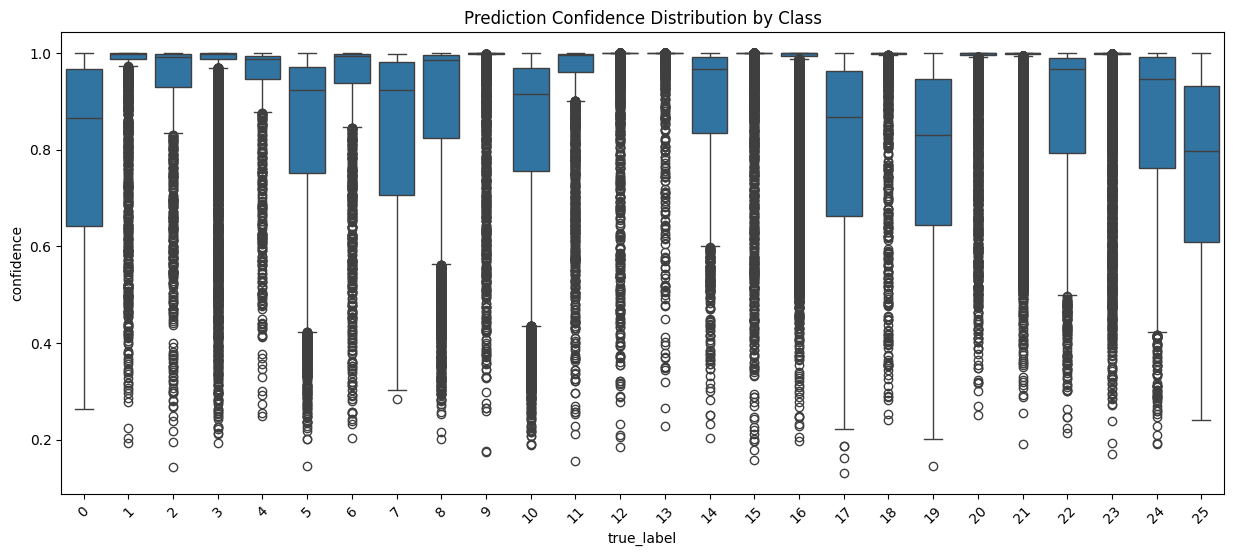


=== Weak Classes Statistics ===
Empty DataFrame
Columns: [class, avg_confidence, med_confidence, std_confidence, samples, low_conf_ratio]
Index: []

=== Strong Classes Statistics ===
Empty DataFrame
Columns: [class, avg_confidence, med_confidence, std_confidence, samples, low_conf_ratio]
Index: []

完整的類別統計資料:
    class  avg_confidence  med_confidence  std_confidence  samples  \
25     25        0.759449        0.796983        0.191675     2144   
19     19        0.782741        0.831085        0.181753     9066   
0       0        0.795497        0.864995        0.191684      196   
17     17        0.801950        0.867576        0.183504     4727   
7       7        0.831173        0.922923        0.188515     1156   
5       5        0.842261        0.923286        0.171348    11534   
10     10        0.842622        0.915420        0.165982    23466   
24     24        0.851274        0.946905        0.187143     1742   
22     22        0.870192        0.967531        0.178226 

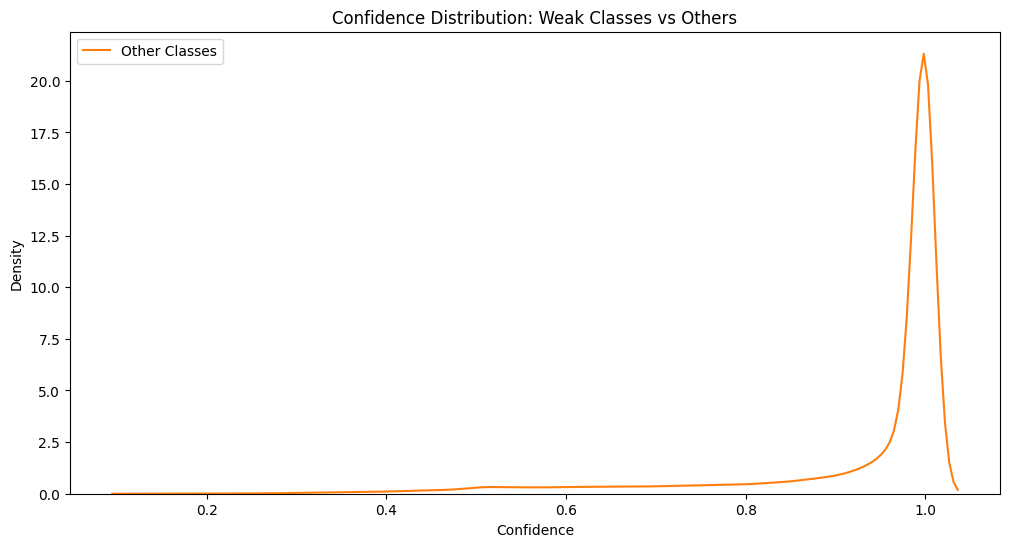

In [2]:
# 執行分析
results_df, stats_df = analyze_bert_confidence()

# 查看詳細的統計數據
print("\n完整的類別統計資料:")
print(stats_df.sort_values('avg_confidence'))

# 可以進一步分析低信心度的分布
threshold = 0.7  # 您可以調整這個閾值
low_conf_samples = results_df[results_df['confidence'] < threshold]
print(f"\n信心度低於 {threshold} 的樣本分布:")
print(low_conf_samples['true_label'].value_counts())

# 繪製額外的視覺化圖表
import seaborn as sns
import matplotlib.pyplot as plt

# 密度圖比較
plt.figure(figsize=(12, 6))
weak_mask = results_df['true_label'].isin(['COVID19_support', 'mentalhealth', 'socialanxiety', 'bipolarreddit', 'lonely'])
sns.kdeplot(data=results_df[weak_mask]['confidence'], label='Weak Classes')
sns.kdeplot(data=results_df[~weak_mask]['confidence'], label='Other Classes')
plt.title('Confidence Distribution: Weak Classes vs Others')
plt.xlabel('Confidence')
plt.ylabel('Density')
plt.legend()
plt.show()

/tmp/ipykernel_2352112/4091677987.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tokenized_data = torch.load('data/processed/tokenized_data.pt')
/tmp/ipykernel_2352112/

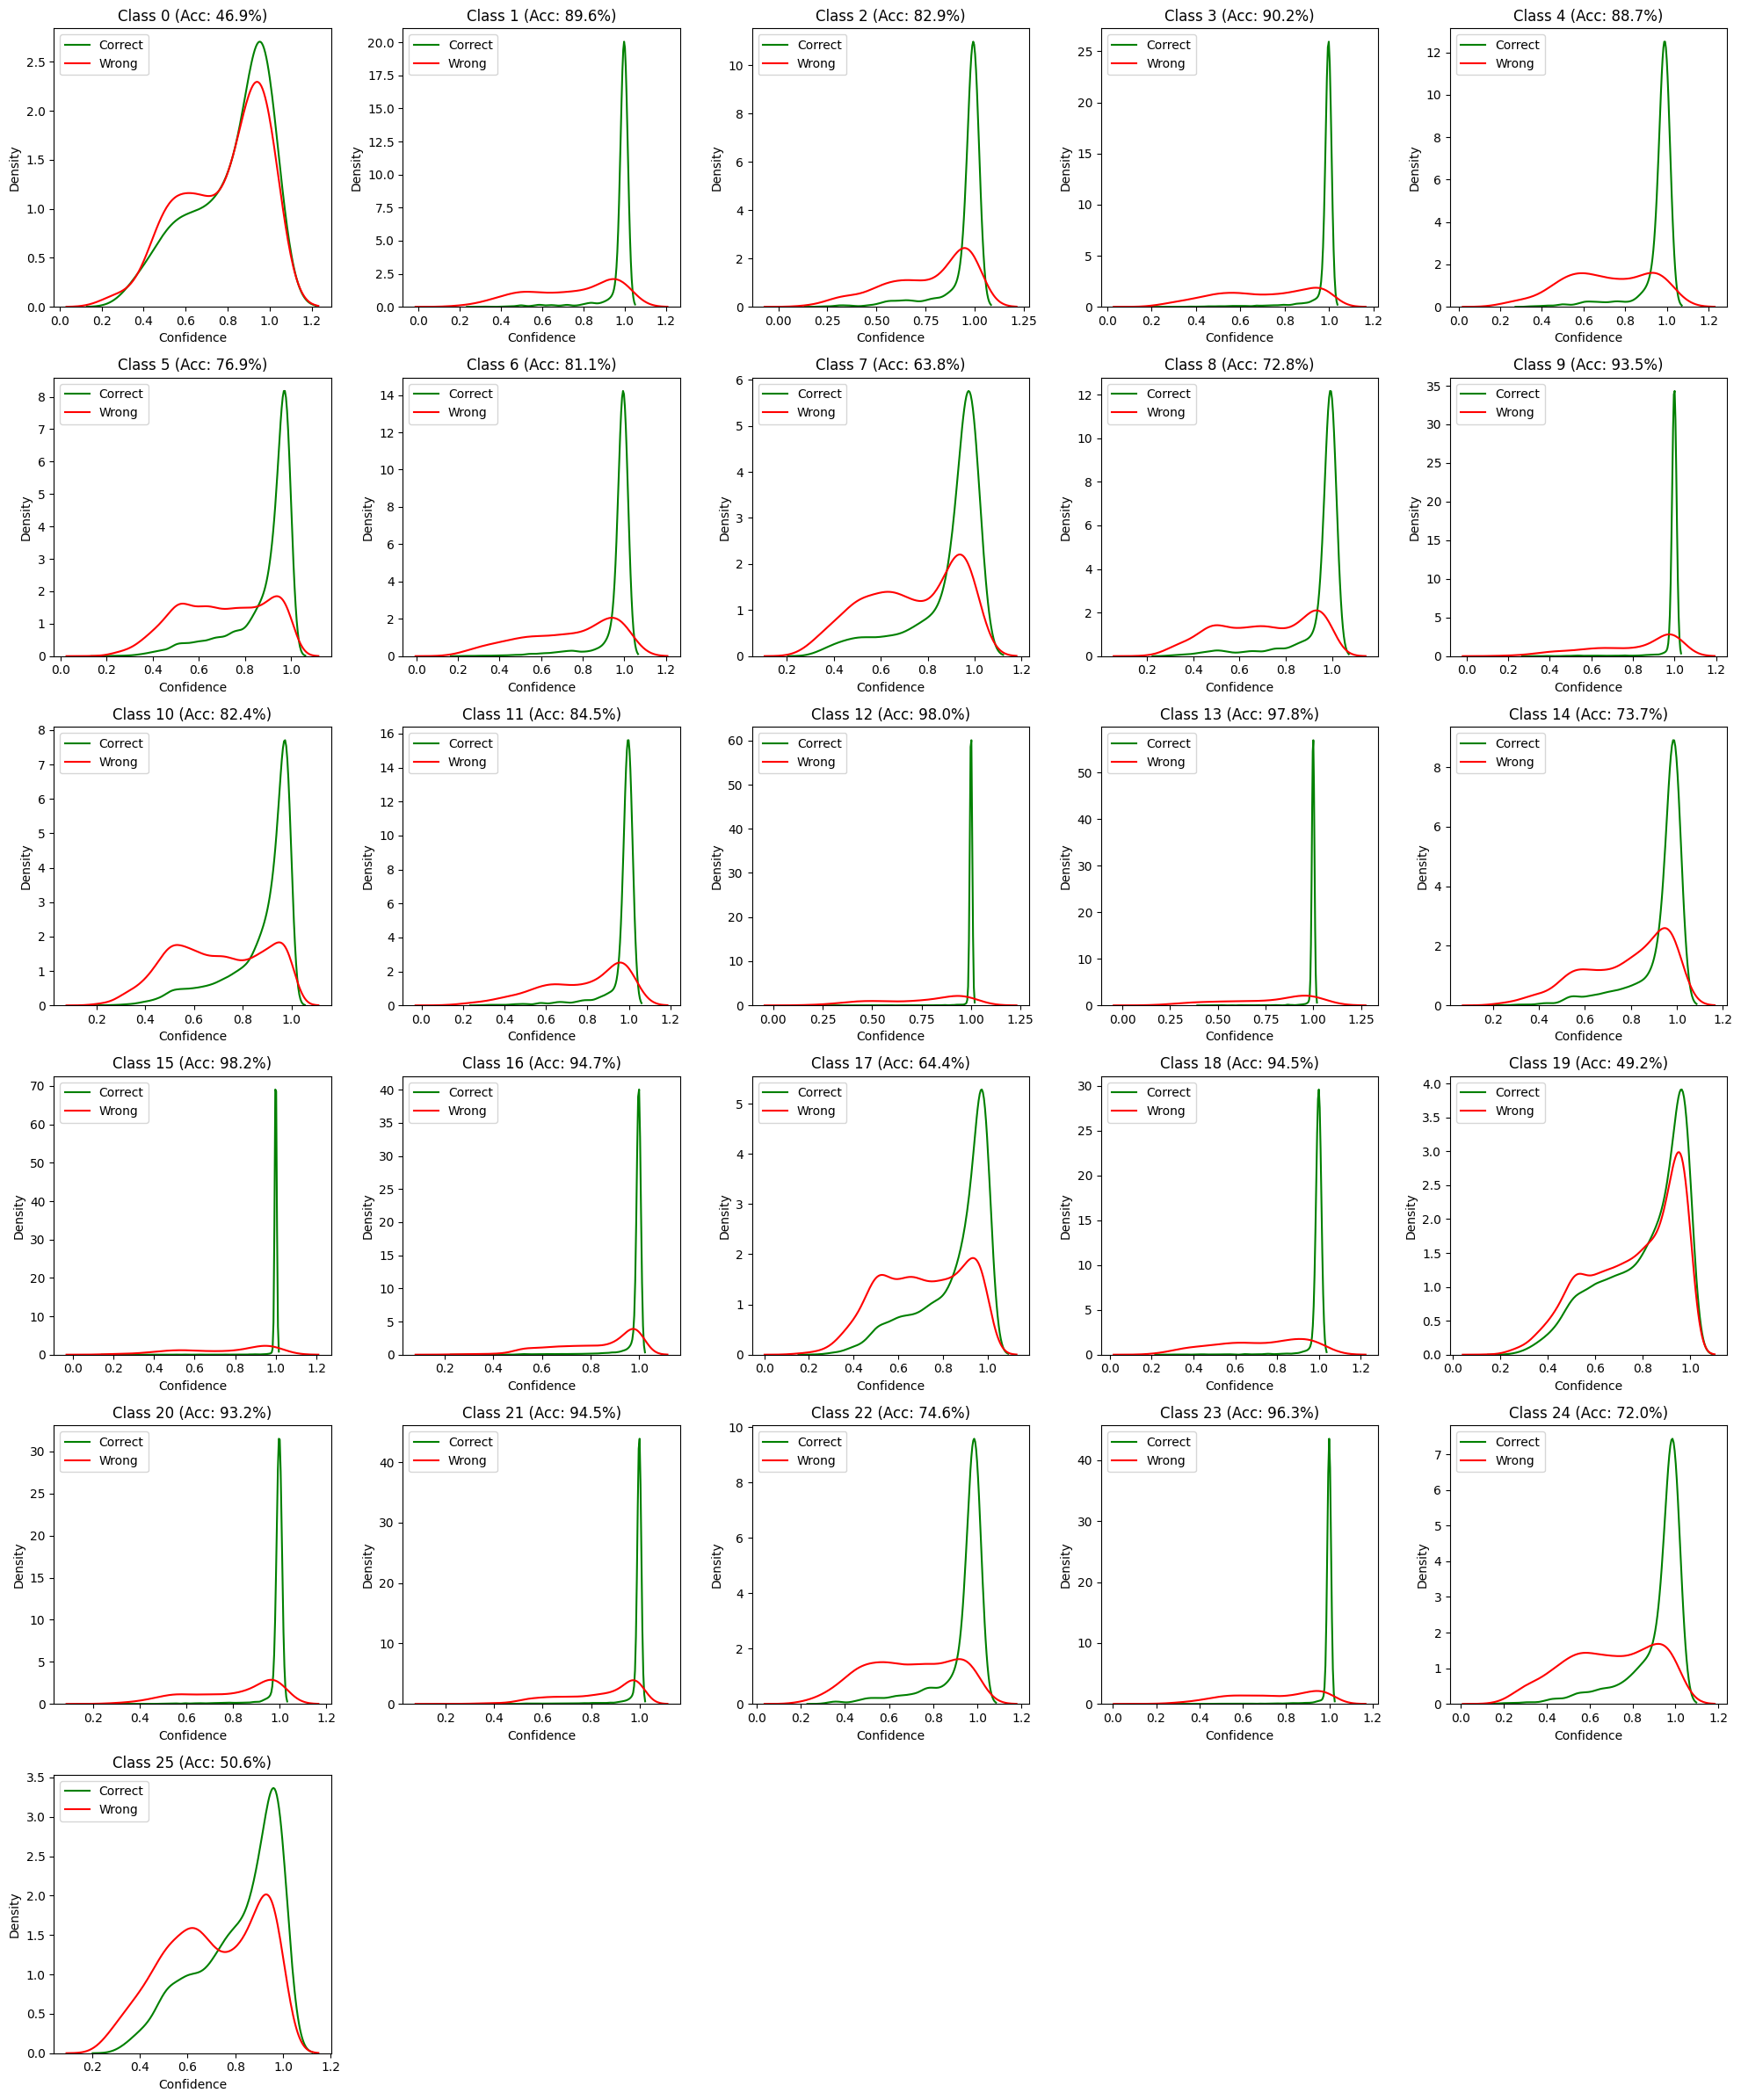


Detailed Statistics for Each Class:
    Class  Total   Accuracy  Correct_Mean_Conf  Correct_Std_Conf  \
0       0    196  46.938776           0.811373          0.186258   
19     19   9066  49.227884           0.804328          0.173302   
25     25   2144  50.559701           0.810309          0.169616   
7       7   1156  63.754325           0.886118          0.156739   
17     17   4727  64.374868           0.853447          0.157392   
24     24   1742  72.043628           0.911292          0.136526   
8       8   4859  72.772175           0.942550          0.125633   
14     14   1730  73.699422           0.925397          0.121643   
22     22   1729  74.609601           0.930933          0.120200   
5       5  11534  76.859719           0.884324          0.139107   
6       6   1774  81.116122           0.962326          0.095627   
10     10  23466  82.395807           0.873764          0.140629   
2       2   1528  82.918848           0.948340          0.116345   
11     11  

In [5]:
def analyze_all_classes_confidence_distribution():
    # 載入數據和模型 (與之前相同)
    tokenized_data = torch.load('data/processed/tokenized_data.pt')
    split_indices = torch.load('data/processed/split_indices.pt')
    test_indices = split_indices['test_indices']
    
    test_input_ids = tokenized_data['input_ids'][test_indices]
    test_attention_masks = tokenized_data['attention_masks'][test_indices]
    test_labels = tokenized_data['labels'][test_indices]
    
    # 模型設置 (與之前相同)
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=26,
        output_attentions=False,
        output_hidden_states=False
    )
    model.load_state_dict(torch.load('base_models/bert/model_state.bin'))
    model.eval()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # 收集預測結果
    results = []
    with torch.no_grad():
        for i in range(0, len(test_input_ids), 32):
            batch_input_ids = test_input_ids[i:i+32].to(device)
            batch_attention_masks = test_attention_masks[i:i+32].to(device)
            batch_true_labels = test_labels[i:i+32]
            
            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            probs = torch.softmax(outputs.logits, dim=1)
            
            max_probs, preds = torch.max(probs, dim=1)
            
            for true_label, pred, conf in zip(
                batch_true_labels.cpu().numpy(),
                preds.cpu().numpy(),
                max_probs.cpu().numpy()
            ):
                results.append({
                    'true_label': true_label,
                    'predicted': pred,
                    'confidence': conf,
                    'correct': true_label == pred
                })
    
    results_df = pd.DataFrame(results)
    
    # 獲取所有唯一的類別
    all_classes = sorted(results_df['true_label'].unique())
    
    # 計算需要的行數和列數
    n_cols = 5  # 每行5個圖
    n_rows = (len(all_classes) + n_cols - 1) // n_cols
    
    # 創建子圖
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    axes = axes.ravel()
    
    # 為每個類別創建分布圖
    for idx, class_id in enumerate(all_classes):
        # 選取該類別的數據
        class_data = results_df[results_df['true_label'] == class_id]
        
        # 分別繪製正確和錯誤預測的分布
        sns.kdeplot(data=class_data[class_data['correct']]['confidence'], 
                   ax=axes[idx], label='Correct', color='green')
        sns.kdeplot(data=class_data[~class_data['correct']]['confidence'], 
                   ax=axes[idx], label='Wrong', color='red')
        
        correct_ratio = (class_data['correct'].sum() / len(class_data)) * 100
        axes[idx].set_title(f'Class {class_id} (Acc: {correct_ratio:.1f}%)')
        axes[idx].set_xlabel('Confidence')
        axes[idx].set_ylabel('Density')
        axes[idx].legend()
    
    # 如果有多餘的子圖，隱藏它們
    for idx in range(len(all_classes), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 打印詳細統計信息
    print("\nDetailed Statistics for Each Class:")
    stats_list = []
    for class_id in all_classes:
        class_data = results_df[results_df['true_label'] == class_id]
        correct_data = class_data[class_data['correct']]
        wrong_data = class_data[~class_data['correct']]
        
        stats = {
            'Class': class_id,
            'Total': len(class_data),
            'Accuracy': len(correct_data)/len(class_data)*100,
            'Correct_Mean_Conf': correct_data['confidence'].mean(),
            'Correct_Std_Conf': correct_data['confidence'].std(),
            'Wrong_Mean_Conf': wrong_data['confidence'].mean() if len(wrong_data) > 0 else 0,
            'Wrong_Std_Conf': wrong_data['confidence'].std() if len(wrong_data) > 0 else 0
        }
        stats_list.append(stats)
    
    stats_df = pd.DataFrame(stats_list)
    print(stats_df.sort_values('Accuracy'))
    
    return results_df, stats_df

# 使用方式：
results_df, stats_df = analyze_all_classes_confidence_distribution()


Loading data and model...


/tmp/ipykernel_2352112/3258885818.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  split_indices = torch.load('data/processed/split_indices.pt')


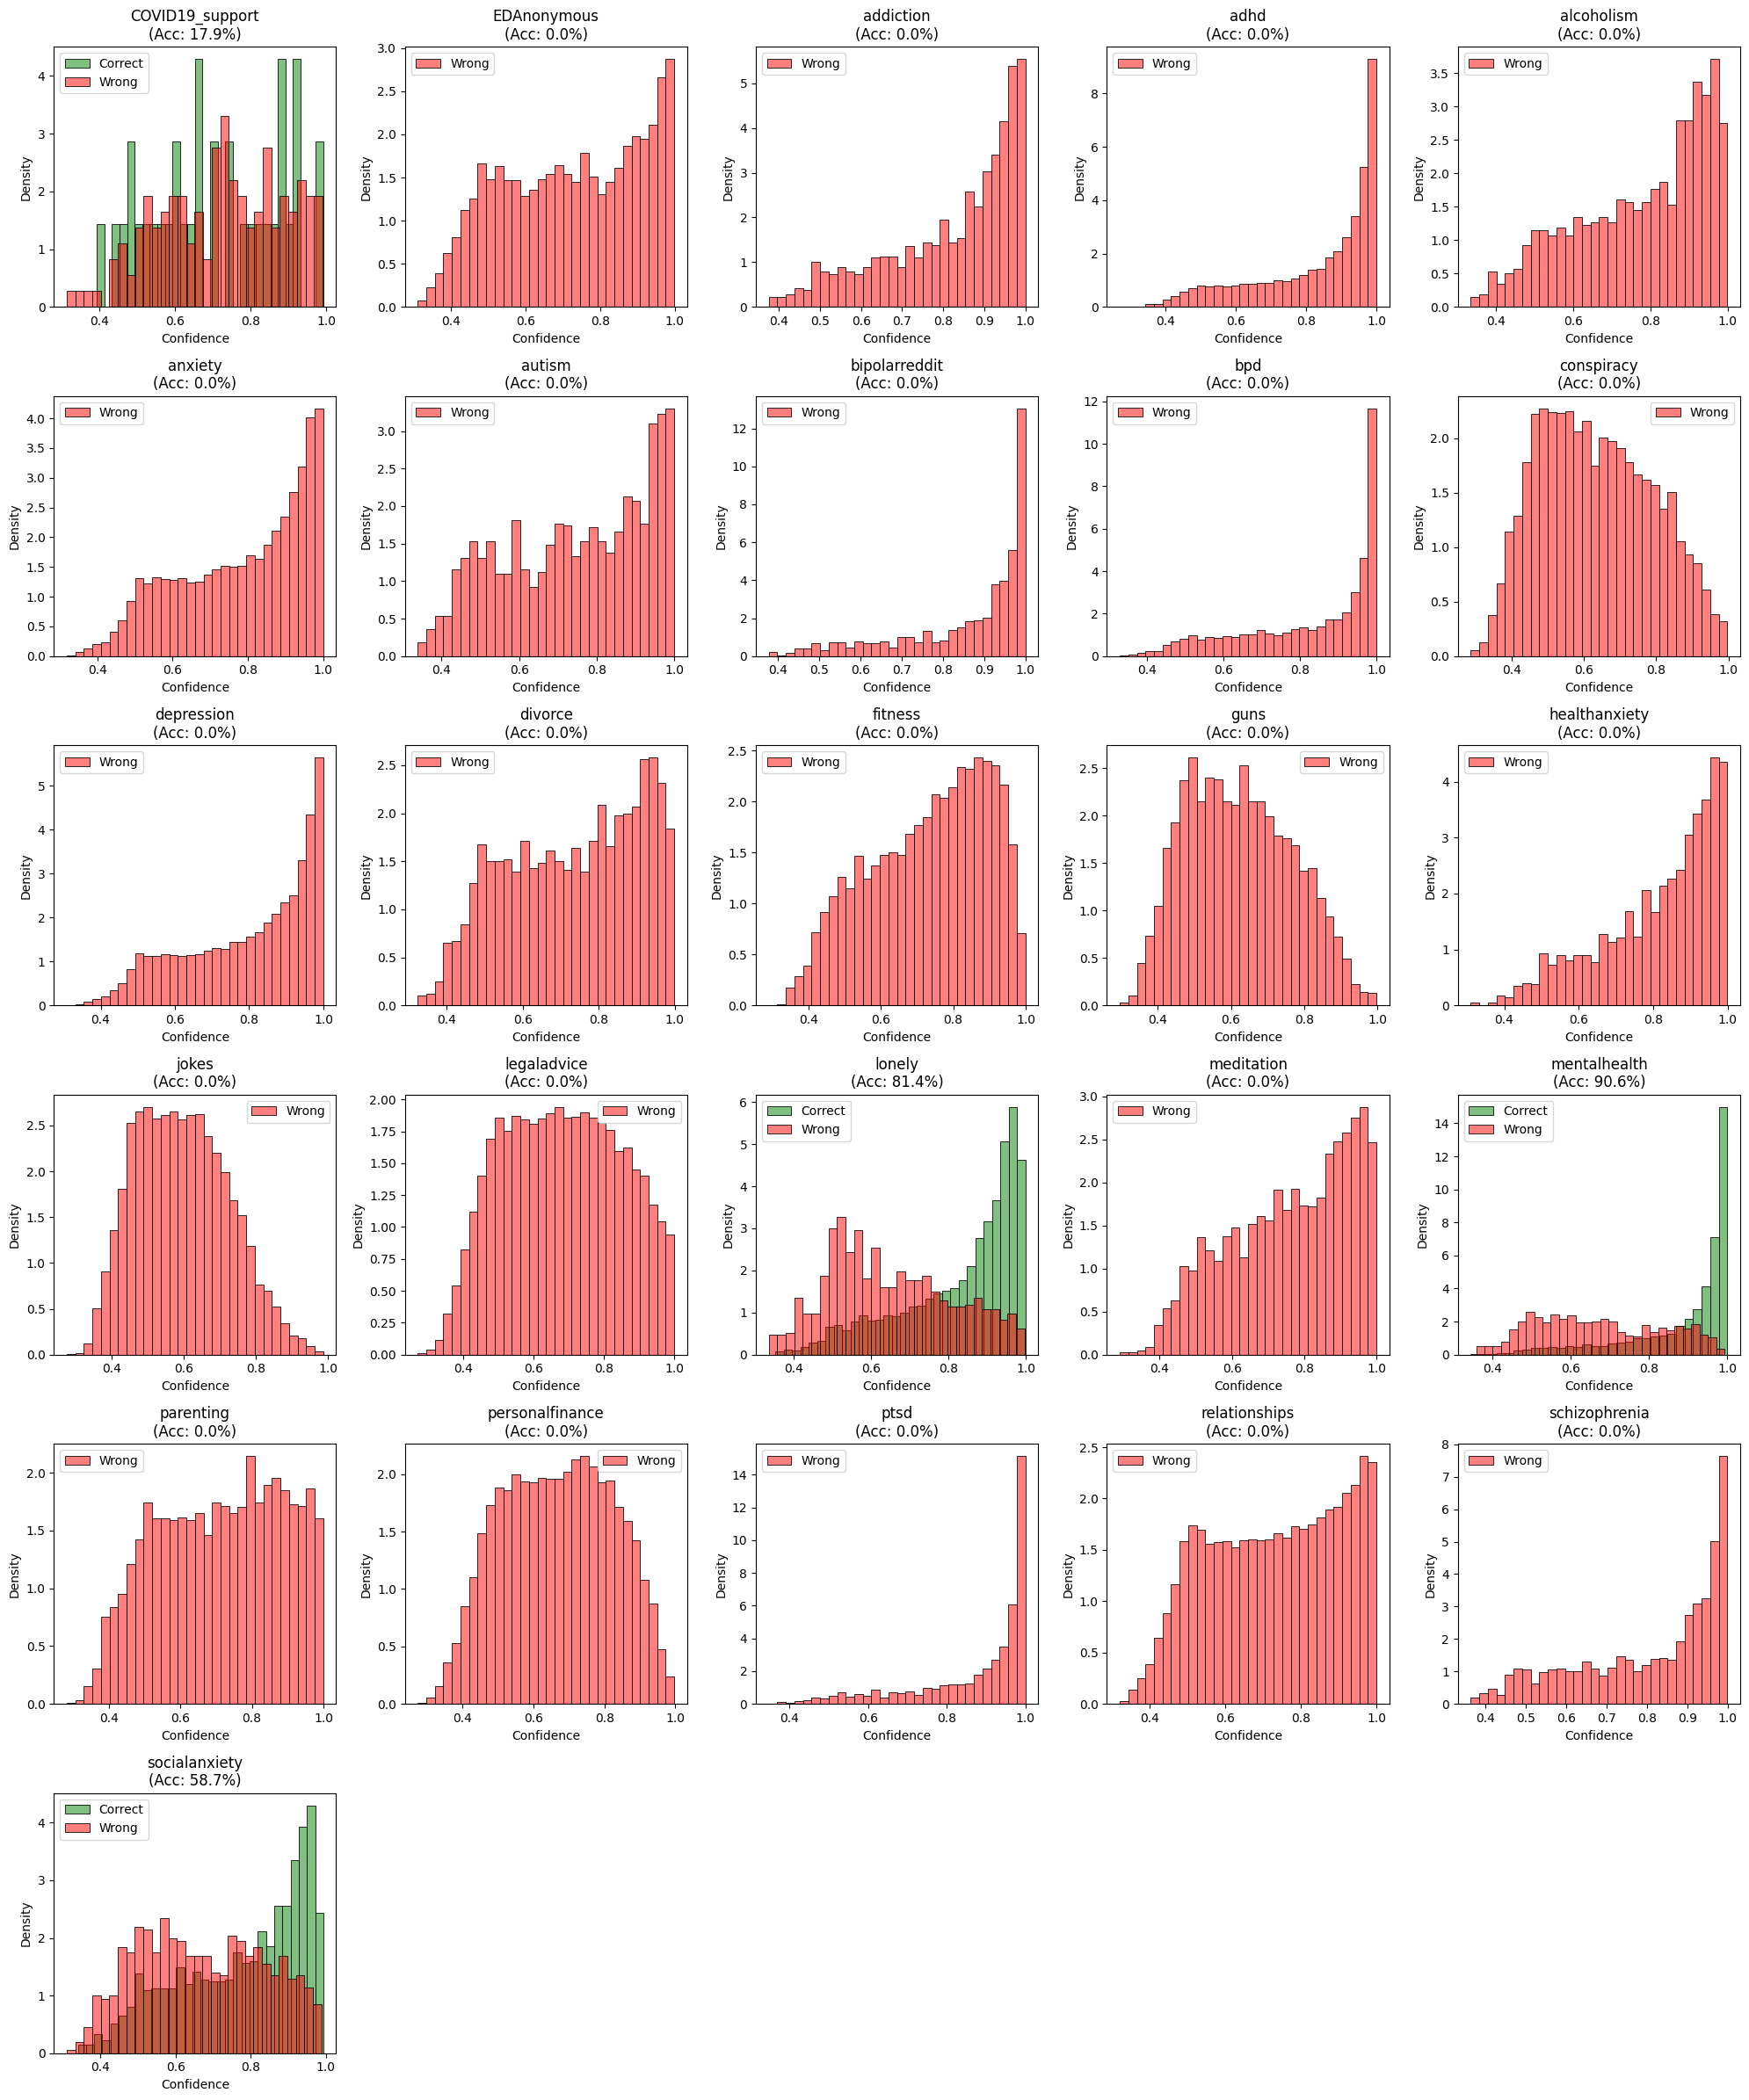


Detailed Statistics for Each Category:
           Category  Total   Accuracy  Correct_Mean_Conf  Correct_Std_Conf  \
19     mentalhealth   9066  90.569159           0.890047          0.135964   
17           lonely   4727  81.447007           0.831240          0.148725   
25    socialanxiety   2144  58.675373           0.777313          0.165235   
0   COVID19_support    196  17.857143           0.706122          0.172858   
2         addiction   1528   0.000000           0.000000          0.000000   
5           anxiety  11534   0.000000           0.000000          0.000000   
6            autism   1774   0.000000           0.000000          0.000000   
3              adhd   9126   0.000000           0.000000          0.000000   
4        alcoholism   1182   0.000000           0.000000          0.000000   
1       EDAnonymous   2915   0.000000           0.000000          0.000000   
9        conspiracy   5969   0.000000           0.000000          0.000000   
8               bpd   48

In [11]:
import pandas as pd
import numpy as np
import torch
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_xgboost_confidence_distribution():
    """分析 XGBoost 模型在所有類別的信心分布"""
    print("\nLoading data and model...")
    
    # 載入數據
    features_data = pd.read_csv('data/processed/features_data.csv')
    split_indices = torch.load('data/processed/split_indices.pt')
    test_indices = split_indices['test_indices']
    
    # 準備測試數據
    X_test = features_data.drop('subreddit', axis=1).iloc[test_indices]
    test_labels = features_data.iloc[test_indices]['subreddit']
    
    # 載入標籤編碼器
    with open('base_models/encoder/label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    test_labels_encoded = label_encoder.transform(test_labels)
    
    # 定義目標類別
    target_categories = ['socialanxiety', 'mentalhealth', 'COVID19_support', 'lonely']
    target_indices = [label_encoder.transform([cat])[0] for cat in target_categories]
    target_to_index = {cat: idx for idx, cat in enumerate(target_categories)}
    
    # 載入 XGBoost 模型
    model = xgb.XGBClassifier()
    model.load_model('base_models/targeted_xgboost/model.json')
    
    # 獲取預測結果和概率
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)
    
    # 將 XGBoost 的預測映射回原始類別空間
    full_probabilities = np.zeros((len(predictions), len(label_encoder.classes_)))
    for i, pred in enumerate(predictions):
        if pred < len(target_categories):  # 確保預測在目標類別範圍內
            orig_idx = target_indices[pred]
            full_probabilities[i, orig_idx] = np.max(probabilities[i])
    
    # 收集結果
    results = []
    for true_label, probs in zip(test_labels_encoded, full_probabilities):
        pred = np.argmax(probs)
        conf = np.max(probs)
        results.append({
            'true_label': true_label,
            'predicted': pred,
            'confidence': conf,
            'correct': true_label == pred,
            'category': label_encoder.inverse_transform([true_label])[0]
        })
    
    results_df = pd.DataFrame(results)
    
    # 繪圖設置
    n_cols = 5
    n_rows = (len(label_encoder.classes_) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    axes = axes.ravel()
    
    # 為每個類別創建分布圖
    for idx, class_id in enumerate(range(len(label_encoder.classes_))):
        class_data = results_df[results_df['true_label'] == class_id]
        
        if len(class_data) > 0:
            # 分別繪製正確和錯誤預測的分布
            correct_data = class_data[class_data['correct']]
            wrong_data = class_data[~class_data['correct']]
            
            if len(correct_data) > 0:
                sns.histplot(data=correct_data['confidence'], 
                           ax=axes[idx], label='Correct', color='green',
                           bins=30, stat='density', alpha=0.5)
            
            if len(wrong_data) > 0:
                sns.histplot(data=wrong_data['confidence'], 
                           ax=axes[idx], label='Wrong', color='red',
                           bins=30, stat='density', alpha=0.5)
                           
        category_name = label_encoder.inverse_transform([class_id])[0]
        correct_ratio = (class_data['correct'].sum() / len(class_data)) * 100 if len(class_data) > 0 else 0
        axes[idx].set_title(f'{category_name}\n(Acc: {correct_ratio:.1f}%)')
        axes[idx].set_xlabel('Confidence')
        axes[idx].set_ylabel('Density')
        axes[idx].legend()
    
    # 隱藏多餘的子圖
    for idx in range(len(label_encoder.classes_), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 打印詳細統計信息
    stats_list = []
    for class_id in range(len(label_encoder.classes_)):
        class_data = results_df[results_df['true_label'] == class_id]
        correct_data = class_data[class_data['correct']]
        wrong_data = class_data[~class_data['correct']]
        
        stats = {
            'Category': label_encoder.inverse_transform([class_id])[0],
            'Total': len(class_data),
            'Accuracy': len(correct_data)/len(class_data)*100 if len(class_data) > 0 else 0,
            'Correct_Mean_Conf': correct_data['confidence'].mean() if not correct_data.empty else 0,
            'Correct_Std_Conf': correct_data['confidence'].std() if not correct_data.empty else 0,
            'Wrong_Mean_Conf': wrong_data['confidence'].mean() if not wrong_data.empty else 0,
            'Wrong_Std_Conf': wrong_data['confidence'].std() if not wrong_data.empty else 0
        }
        stats_list.append(stats)
    
    stats_df = pd.DataFrame(stats_list)
    print("\nDetailed Statistics for Each Category:")
    print(stats_df.sort_values('Accuracy', ascending=False))
    
    return results_df, stats_df

# 使用方式：
results_df, stats_df = analyze_xgboost_confidence_distribution()

/tmp/ipykernel_2352112/1274807130.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  split_indices = torch.load('data/processed/split_indices.pt')


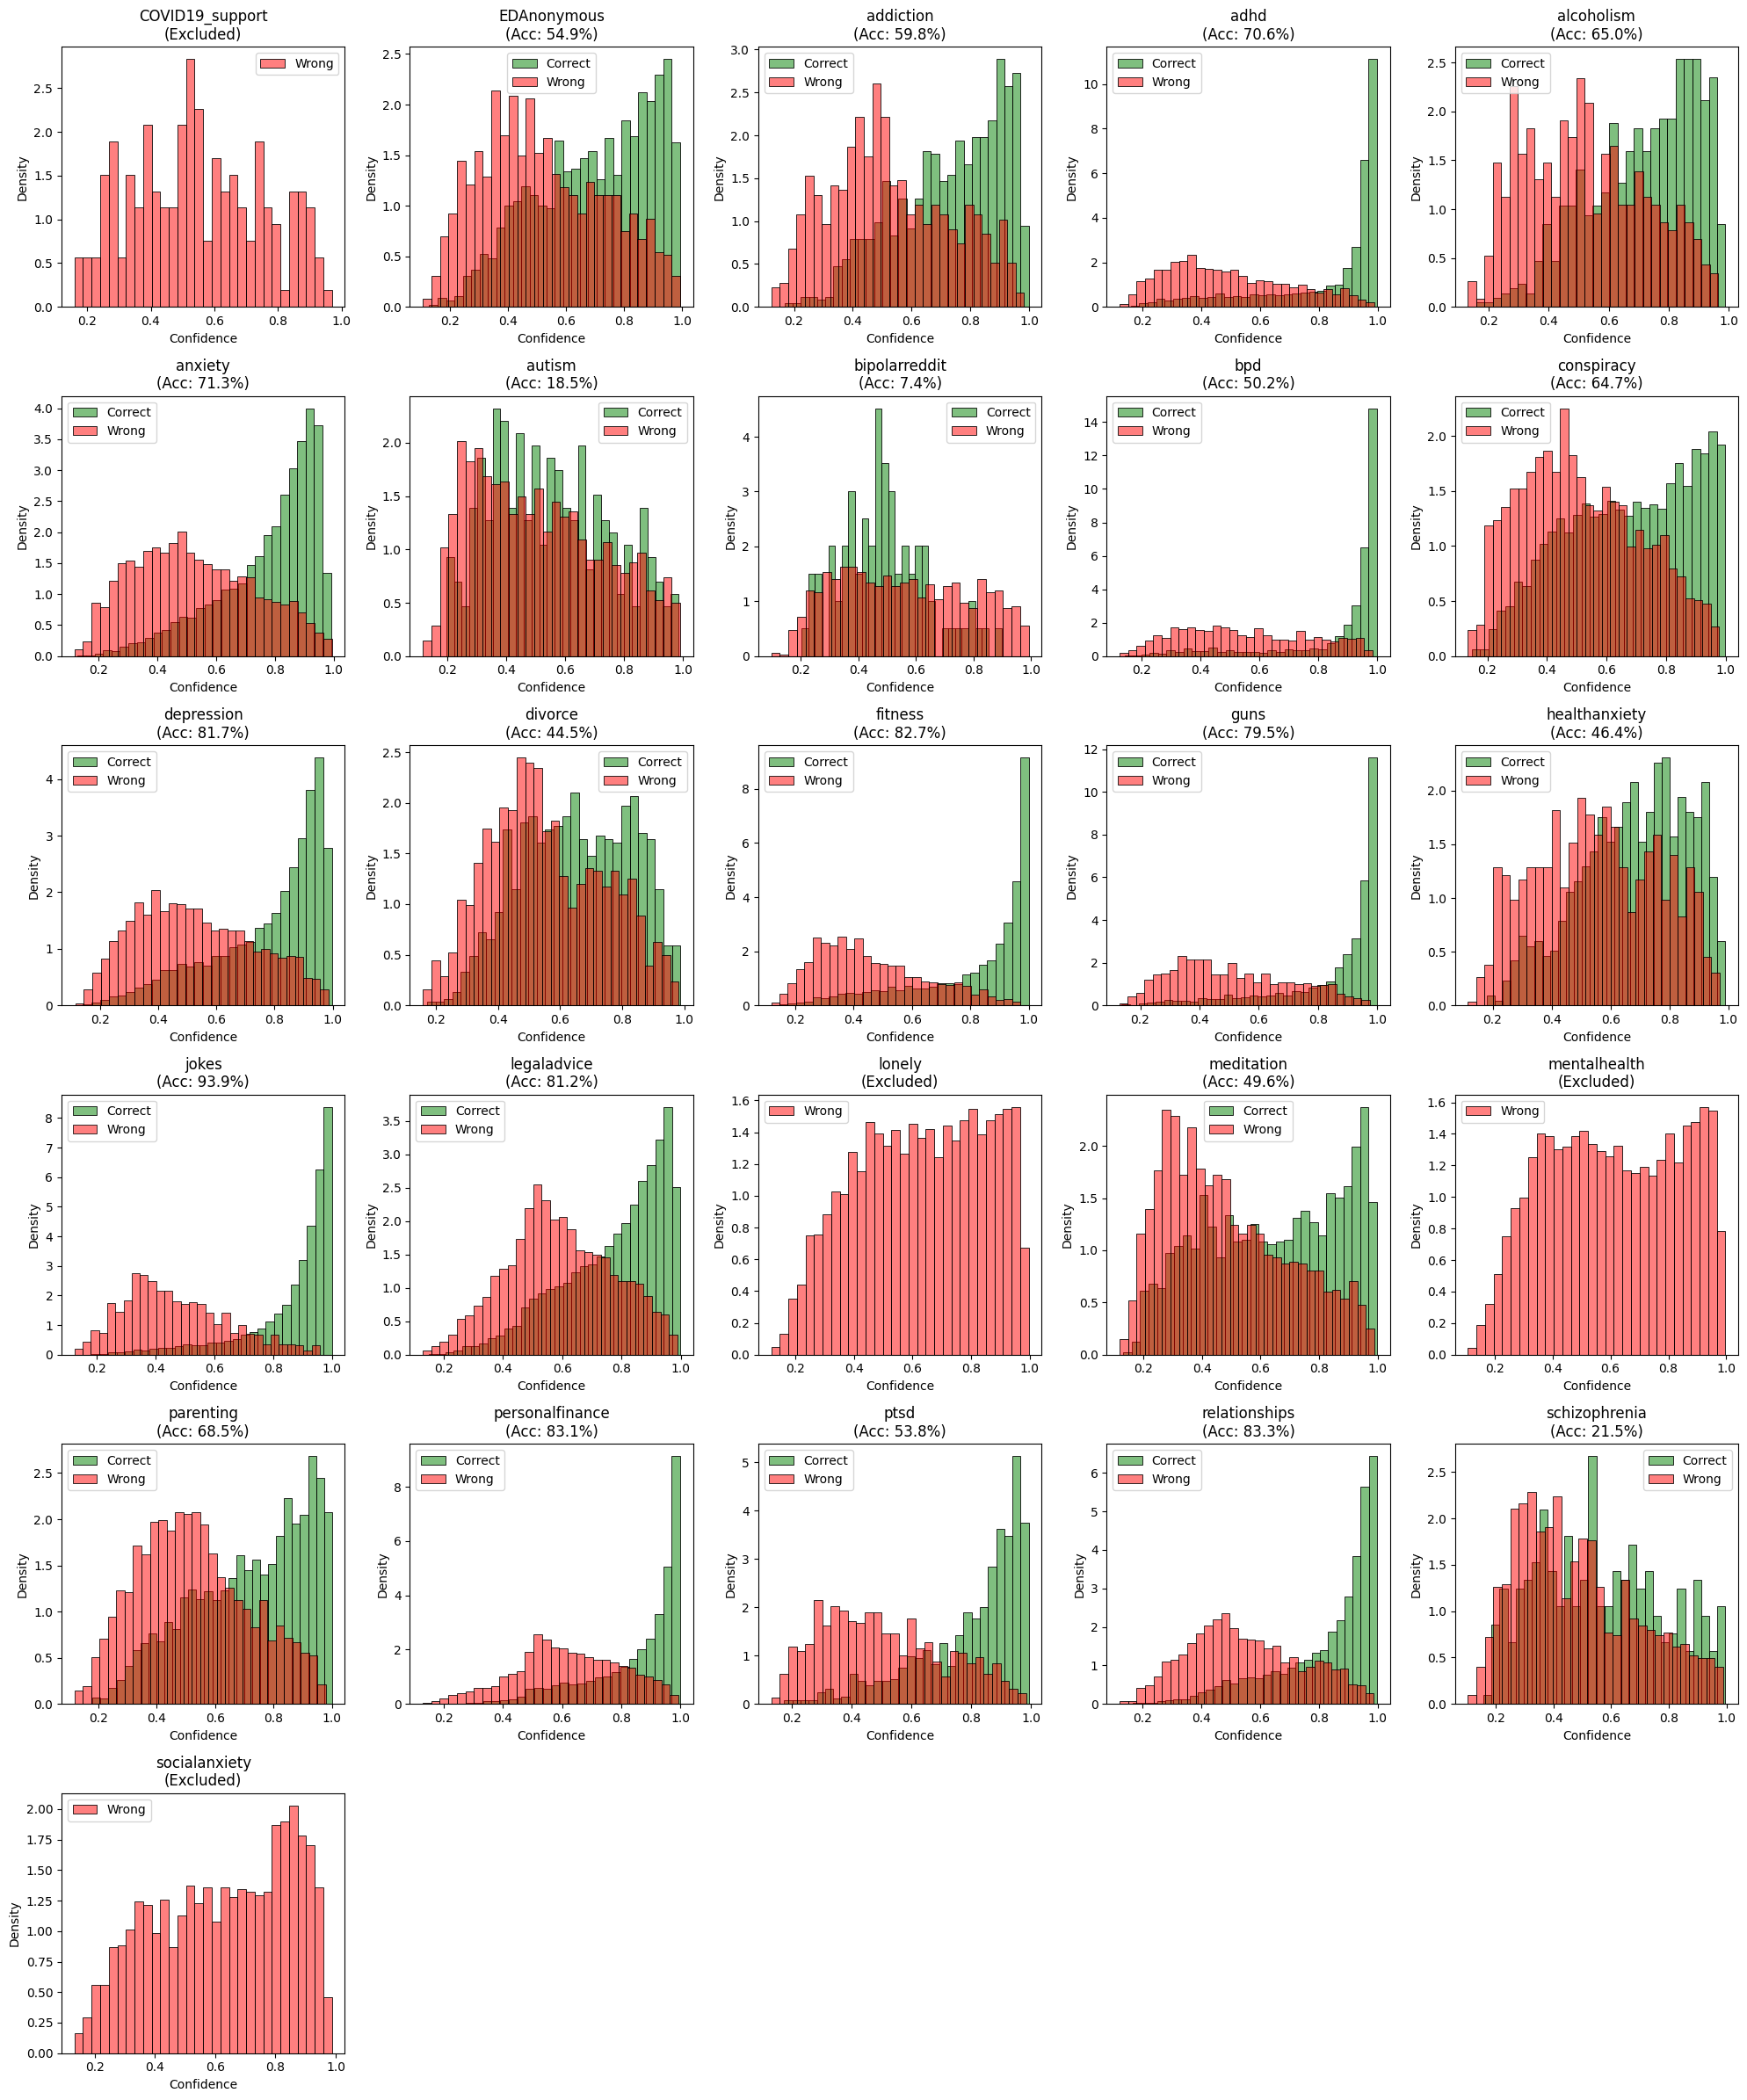


Statistics for Included Categories:
           Category  Excluded  Total   Accuracy  Correct_Mean_Conf  \
15            jokes     False  18901  93.862759           0.866178   
23    relationships     False  15444  83.320383           0.827112   
21  personalfinance     False  25628  83.081005           0.851506   
12          fitness     False   9969  82.726452           0.817047   
10       depression     False  23466  81.654308           0.777069   
16      legaladvice     False  32847  81.170274           0.776653   
13             guns     False   4595  79.477693           0.861367   
5           anxiety     False  11534  71.250217           0.776596   
3              adhd     False   9126  70.611440           0.832687   
20        parenting     False   6774  68.497195           0.719796   
4        alcoholism     False   1182  64.974619           0.717732   
9        conspiracy     False   5969  64.734461           0.676492   
2         addiction     False   1528  59.751309      

In [12]:
import pandas as pd
import numpy as np
import torch
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json

# 載入數據
features_data = pd.read_csv('data/processed/features_data.csv')
split_indices = torch.load('data/processed/split_indices.pt')
test_indices = split_indices['test_indices']

# 準備測試數據
X_test = features_data.drop('subreddit', axis=1).iloc[test_indices]
test_labels = features_data.iloc[test_indices]['subreddit']

# 載入標籤編碼器
with open('base_models/encoder/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)
test_labels_encoded = label_encoder.transform(test_labels)

# 載入模型配置以獲取映射關係
with open('base_models/xgboost_22cls/config.json', 'r') as f:
    config = json.load(f)
target_mapping = config['target_mapping']

# 載入XGBoost模型
model = xgb.XGBClassifier()
model.load_model('base_models/xgboost_22cls/model.json')

# 獲取預測結果和概率
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)

# 將XGBoost的預測映射回原始類別空間
full_probabilities = np.zeros((len(predictions), len(label_encoder.classes_)))
for i, pred in enumerate(predictions):
    mapped_idx = target_mapping['new_to_original'].get(str(int(pred)), -1)
    if mapped_idx != -1:
        full_probabilities[i, int(mapped_idx)] = np.max(probabilities[i])

# 收集結果
results = []
for true_label, probs in zip(test_labels_encoded, full_probabilities):
    pred = np.argmax(probs)
    conf = np.max(probs)
    # 只在模型有預測結果時記錄信心值
    if conf > 0:
        results.append({
            'true_label': true_label,
            'predicted': pred,
            'confidence': conf,
            'correct': true_label == pred,
            'category': label_encoder.inverse_transform([true_label])[0]
        })

results_df = pd.DataFrame(results)

# 繪圖設置
n_cols = 5
n_rows = (len(label_encoder.classes_) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.ravel()

# 計算要排除的類別
excluded_categories = ['socialanxiety', 'mentalhealth', 'COVID19_support', 'lonely']
excluded_indices = [label_encoder.transform([cat])[0] for cat in excluded_categories]

# 為每個類別創建分布圖
for idx, class_id in enumerate(range(len(label_encoder.classes_))):
    class_data = results_df[results_df['true_label'] == class_id]
    category_name = label_encoder.inverse_transform([class_id])[0]
    
    if len(class_data) > 0:
        # 分別繪製正確和錯誤預測的分布
        correct_data = class_data[class_data['correct']]
        wrong_data = class_data[~class_data['correct']]
        
        if len(correct_data) > 0:
            sns.histplot(data=correct_data['confidence'], 
                       ax=axes[idx], label='Correct', color='green',
                       bins=30, stat='density', alpha=0.5)
        
        if len(wrong_data) > 0:
            sns.histplot(data=wrong_data['confidence'], 
                       ax=axes[idx], label='Wrong', color='red',
                       bins=30, stat='density', alpha=0.5)
        
    correct_ratio = (class_data['correct'].sum() / len(class_data)) * 100 if len(class_data) > 0 else 0
    
    # 標記是否為排除的類別
    title = f'{category_name}\n'
    if class_id in excluded_indices:
        title += '(Excluded)'
    else:
        title += f'(Acc: {correct_ratio:.1f}%)'
    
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Confidence')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()

# 隱藏多餘的子圖
for idx in range(len(label_encoder.classes_), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# 打印詳細統計信息
stats_list = []
for class_id in range(len(label_encoder.classes_)):
    class_data = results_df[results_df['true_label'] == class_id]
    correct_data = class_data[class_data['correct']]
    wrong_data = class_data[~class_data['correct']]
    category_name = label_encoder.inverse_transform([class_id])[0]
    
    stats = {
        'Category': category_name,
        'Excluded': category_name in excluded_categories,
        'Total': len(class_data),
        'Accuracy': len(correct_data)/len(class_data)*100 if len(class_data) > 0 else 0,
        'Correct_Mean_Conf': correct_data['confidence'].mean() if not correct_data.empty else 0,
        'Correct_Std_Conf': correct_data['confidence'].std() if not correct_data.empty else 0,
        'Wrong_Mean_Conf': wrong_data['confidence'].mean() if not wrong_data.empty else 0,
        'Wrong_Std_Conf': wrong_data['confidence'].std() if not wrong_data.empty else 0
    }
    stats_list.append(stats)

stats_df = pd.DataFrame(stats_list)
# 分別顯示包含和排除的類別統計
print("\nStatistics for Included Categories:")
print(stats_df[~stats_df['Excluded']].sort_values('Accuracy', ascending=False))
print("\nStatistics for Excluded Categories (Should be empty or near zero):")
print(stats_df[stats_df['Excluded']].sort_values('Accuracy', ascending=False))